# Max Q and Atmospheric Drag

The max q condition is the point in an aerospace vehicle's atmospheric flight reaches maximum dynamic pressure. This is a significant factor in the design of such vehicles because the aerodynamic structural load on them is proportional to dynamic pressure.
Q can be considered as the kinetic energy of a unit mass of air. 

In [1]:
import numpy as np

## Theory

### Dynamic pressure

Dynamic pressure q can be thought of as the kinetic energy density of the air with respect to the vehicle. 

It is defined mathematically as

$\large q={\tfrac {1}{2}}\rho v^{2} $

$\rho$ - local air density

$v$ - vehicle velocity

In [2]:
def dynamic_pressure(rho:float, v:float) -> float:
    q = 1 / 2 * rho * v**2
    return q

### Air density 

Air density can be calculated according to a molar form of the ideal gas law:

$\large \rho ={\frac {pM}{RT}} $

$p$ - absolute pressure

$M$ - molar mass of dry air, 0.0289644 kg/mol

$R$ - ideal (universal) gas constant, 8.31447 J/(mol·K)

$T$ - absolute temperature

In [3]:
M = 0.0289644
R = 8.31447

def local_air_density(T:float, p:float) -> float:
    rho = (p * M) / (R * T)
    return rho

### Temperature at altitude h

Temperature at altitude h meters above sea level is approximated by the following formula (only valid inside the troposphere, no more than ~18 km above Earth's surface (and lower away from Equator)).

$\large T=T_{0}-Lh$ 

$T_0$ - sea level standard temperature, 288.15 K

$L$ - temperature lapse rate, 0.0065 K/m

$h$ - altitude in meters

In [4]:
T_0 = 288.15
L = 0.0065

def temp_at_h(h:float) -> float:
    T = T_0 - L * h
    return T

### Pressure at altitude h

$\large p=p_{0}\left(1-{\frac {Lh}{T}}\right)^{\frac {g_0M}{RL}} $

$p_0$ - sea level standard atmospheric pressure, 101.325 kPa

$g_0$ - earth-surface gravitational acceleration, 9.80665 m/s²

In [5]:
p_0 = 101.325
G_0 = 9.80665

def press_at_h(h:float, T:float) -> float:
    frac = ((G_0 * M) / (R * L))
    p = p_0 * ((1.0 - ((L * h) / T)) ** frac)
    return p

## Atmospheric Drag

$\large F_d = C_d * A * q$

$C_d$ - Drag coefficient

$A$ - Area in $m^2$

In [6]:
def drag(Cd, A, q):
    return Cd * A * q

## Example - max Q of Falcon 9 v1.2

In [7]:
import matplotlib.pyplot as plt
import matplotlib

In [8]:
import json

# get data calculated in velocity_and_distance.ipynb notebook
# it contains flight profiles of Falcon 9 launched at 0, 30, 45, 60 and 90 degrees
# for simplicity, let's assume the vehicle is traveling straight up (0 degrees)

with open('falcon_9_vel_dist_alt.json') as fp:
    vel_dist_alt = json.load(fp)

stage_id = 0
degree_id = 0

t_1st_stage = np.array(vel_dist_alt['stages'][stage_id]['time'])
v_1st_stage = np.array(vel_dist_alt['stages'][stage_id]['velocity'][degree_id])
d_h_1st_stage = np.array(vel_dist_alt['stages'][stage_id]['horizontal_distance'][degree_id])
d_v_1st_stage = np.array(vel_dist_alt['stages'][stage_id]['vertical_distance'][degree_id])

# calculate when vehicle is below 18km
mask_18k = d_v_1st_stage < 18000

In [9]:
d = d_h_1st_stage[mask_18k]

In [10]:
# calculate air density
h = d_v_1st_stage[mask_18k]
T = temp_at_h(h)
p = press_at_h(h, T)
rho = local_air_density(T, p)

### Visualize temperature, air pressure and density

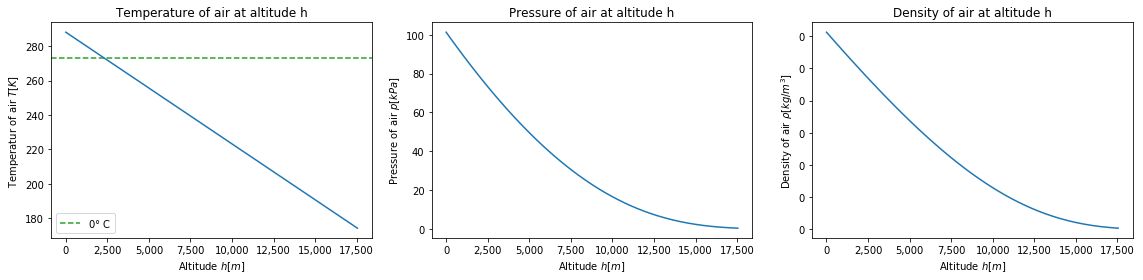

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)))

ax[0].get_xaxis().set_major_formatter(formatter)
ax[0].get_yaxis().set_major_formatter(formatter)
ax[0].axhline(273.15, c='C2', linestyle='--', label='0$\degree$ C')
ax[0].set_xlabel('Altitude $h[m]$')
ax[0].set_ylabel('Temperatur of air $T[K]$')
ax[0].plot(h, T)
ax[0].set_title('Temperature of air at altitude h')
ax[0].legend(loc='lower left')

ax[1].get_xaxis().set_major_formatter(formatter)
ax[1].get_yaxis().set_major_formatter(formatter)
ax[1].set_xlabel('Altitude $h[m]$')
ax[1].set_ylabel('Pressure of air $p[kPa]$')
ax[1].plot(h, p)
ax[1].set_title('Pressure of air at altitude h')

ax[2].get_xaxis().set_major_formatter(formatter)
ax[2].get_yaxis().set_major_formatter(formatter)
ax[2].set_xlabel('Altitude $h[m]$')
ax[2].set_ylabel('Density of air $ \\rho [kg/m^3]$')
ax[2].plot(h, rho)
ax[2].set_title('Density of air at altitude h')

plt.tight_layout()
plt.show();

### Valculate dynamic pressure and atmospheric drag

In [12]:
# calculate dynamic pressure
v = v_1st_stage[mask_18k]
q = dynamic_pressure(rho, v)

In [13]:
# calculate max Q
max_q = q.max()
max_q_id = q.argmax()
max_q

20.13077391332496

In [14]:
# calculate atmospheric drag

# calculate area and drag coefficient assuming shape of Falcon fairing is a perfect cone
r = 5.2 / 2 # accorindg to SpaceX Falcon 9 user's guide 
l = 5
A = np.pi * r * l

Cd = 0.5 # drag coefficient for a perfect cone

Fd = drag(Cd, A, q)

In [15]:
t = t_1st_stage[mask_18k]

### Visualize

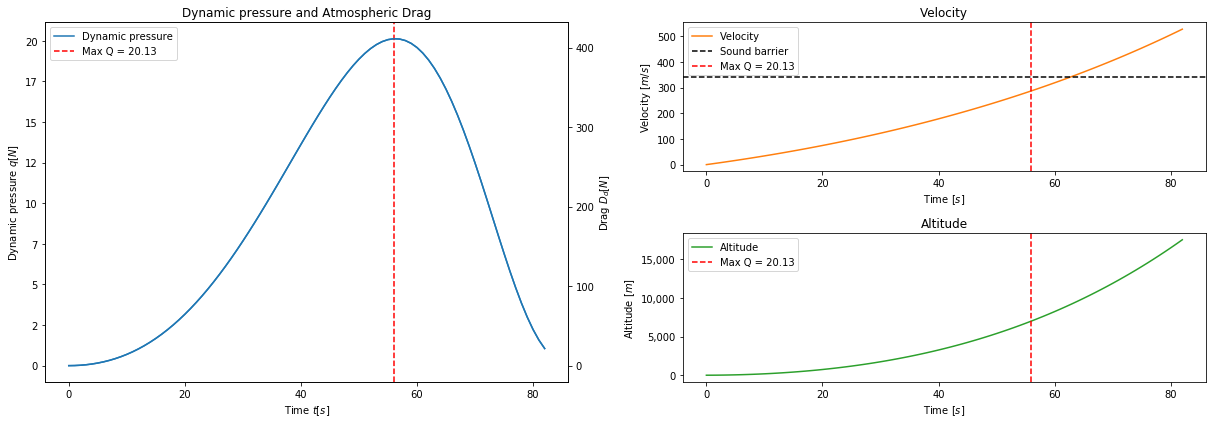

In [16]:
fig = plt.figure(figsize=(17, 6))
ax0 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((2, 2), (0, 1))
ax2 = plt.subplot2grid((2, 2), (1, 1))

formatter = matplotlib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)))

ax01 = ax0.twinx()

ax0.plot(t, q, c='C0', label='Dynamic pressure')
ax0.get_yaxis().set_major_formatter(formatter)
ax0.set_xlabel('Time $t[s]$')
ax0.set_ylabel('Dynamic pressure $q[N]$')
ax0.set_title('Dynamic pressure and Atmospheric Drag')
ax0.axvline(max_q_id, c='red', linestyle='--', label='Max Q = {:,.2f}'.format(max_q))
ax0.legend(loc='upper left')

ax01.plot(t, Fd, c='C0', label='Drag')
ax01.set_ylabel('Drag $D_d[N]$')


ax1.plot(t, v, c='C1', label='Velocity')
ax1.get_yaxis().set_major_formatter(formatter)
ax1.axhline(343, color='k', linestyle='--', label='Sound barrier')
ax1.axvline(max_q_id, c='red', linestyle='--', label='Max Q = {:,.2f}'.format(max_q))
ax1.set_title('Velocity')
ax1.set_xlabel('Time [$s$]')
ax1.set_ylabel('Velocity [$m/s$]')
ax1.legend(loc='upper left')

ax2.plot(t, h, c='C2', label='Altitude')
ax2.get_yaxis().set_major_formatter(formatter)
ax2.axvline(max_q_id, c='red', linestyle='--', label='Max Q = {:,.2f}'.format(max_q))
ax2.set_title('Altitude')
ax2.set_xlabel('Time [$s$]')
ax2.set_ylabel('Altitude [$m$]')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show();

In [17]:
t[max_q_id], v[max_q_id], h[max_q_id], Fd[max_q_id]

(56, 287.47439023289724, 7014.00340268842, 411.07749434166186)

**Observe**

- Maximum dynamic pressure for Falcon 9 occurs 56s after lift-off, at approx 7km
- Maximum dynamic pressure pressure is around 20kPa, which is equivalent to 2,000 kg sitting on a 1 square meter surface
- Atmospheric drag reaches 411N
- This value is significantly different from the data published by SpaceX and observed during launch, reasons:
   - Vehicle is not moving straght up
   - Vehicle is throttling down before reaching Max Q to prevent structural damage

# Sources

- https://en.wikipedia.org/wiki/Max_Q
- https://en.wikipedia.org/wiki/Density_of_air
- https://spacex.com/sites/spacex/files/falcon_9_users_guide_rev_2.0.pdf
- https://mcleodsean.wordpress.com/2018/01/10/max-q-maximum-dynamic-pressure/
- http://orbitalaspirations.blogspot.com/2018/05/max-q-and-dynamic-pressure.html
- https://www.reddit.com/r/spacex/comments/6303ko/falcon_9_full_thrust_flight_analysis/
- https://i.redd.it/8mwqvbd2n5py.png
- https://docs.google.com/spreadsheets/d/1EQQzFFkUU8mJWFaL9ityp0Q5hNUjCPji7Amzx09ubiY/edit#gid=0
- https://en.wikipedia.org/wiki/Drag_coefficient
- https://en.wikipedia.org/wiki/Drag_(physics)#Aerodynamics
- https://space.stackexchange.com/questions/744/effect-of-atmospheric-drag-on-rocket-launches-and-benefits-of-high-altitude-laun